## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [249]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [250]:
# Opening JSON file 
f = open("complaints-2021-05-14_08_16.json","r")
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [251]:
# Inspect the dataframe to understand the given data.
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [252]:
print(df["_source.sub_product"].value_counts())

Checking account                              17182
General-purpose credit card or charge card    10504
Other mortgage                                 8447
Conventional fixed mortgage                    4892
Credit reporting                               4172
                                              ...  
Government benefit payment card                   4
Gift or merchant card                             4
ID prepaid card                                   2
Medical debt                                      2
Electronic Benefit Transfer / EBT card            1
Name: _source.sub_product, Length: 72, dtype: int64


In [253]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [254]:
#Assign new column names
# For simplicity and avoiding "." values in column, let us remove '^_|_source.' from column names. 

newcols = [ y.replace('source.','',1) for y in [ x.replace('_','',1) for x in df.columns ]]    
df.columns = newcols
print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [255]:
# let us check shape of the dataframe
print(df.shape)
print(df.isnull().values.any())
print(df.isnull().values.sum())

(78313, 22)
True
212346


In [256]:
# let us check non-numerical columns
df.describe(exclude="number")

,index,type,id,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
count,78313,78313,78313,10900,71556,78313,78313,78313,76322,78313,...,78313,78313,78313,78313,4,67742,78313,78313,32016,77305
unique,1,1,78313,3,9442,78313,154,3444,62,3,...,8,1,6,3309,3,72,2,20931,205,5
top,complaint-public-v2,complaint,260735,Older American,606XX,260735,"Loan modification,collection,foreclo...",2015-08-27T12:00:00-05:00,CA,N/A,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2012-06-21T12:00:00-05:00,Company has responded to the consume...,Checking account,Yes,,Credit card company isn't resolving ...,N/A
freq,78313,78313,1,6103,472,1,9743,82,14009,35683,...,60230,78313,47972,105,2,17182,78217,57241,2904,42847


In [257]:
# Do we have Duplicate records ?
n_duplicates = df.drop(labels=['id'],axis=1).duplicated().sum()
print(n_duplicates)

# conclusion - no duplicates, unique IDs

0


In [258]:
# drop columns with only 1 or less type of value in addition to few more not adding value to analysis.
cols_valcounts = {}
col_valcounts = { cols:df[cols].unique() for cols in df.columns }
cols_to_drop = [ col for col,val in col_valcounts.items() if len(val) <=1 ]
print(len(cols_to_drop), cols_to_drop)

4 ['index', 'type', 'score', 'company']


In [259]:
for each_col in cols_to_drop:
    print("---%s---".format(each_col))
    print(df[each_col].value_counts())

---%s---
complaint-public-v2    78313
Name: index, dtype: int64
---%s---
complaint    78313
Name: type, dtype: int64
---%s---
0.0    78313
Name: score, dtype: int64
---%s---
JPMORGAN CHASE & CO.    78313
Name: company, dtype: int64


In [260]:
# Let us drop above 4 columns in cols_to_drop given they have unique values and don't add any new info in learning
df = df.drop(columns=cols_to_drop)

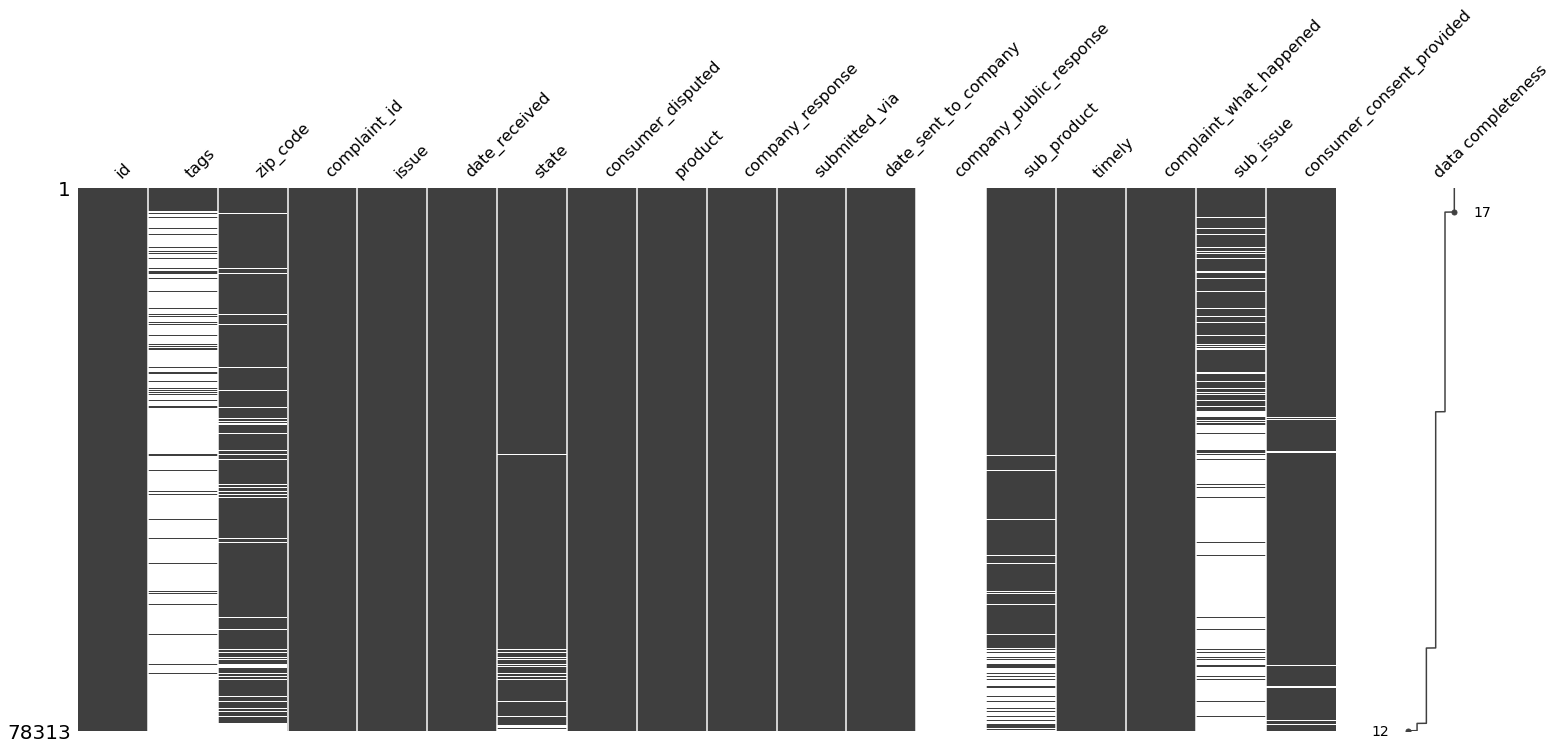

In [261]:
# Let us find any missing values across features for samples - horizontal investigation
import missingno as msno
msno.matrix(df,labels=True,sort="descending")

In [262]:
df["tags"].value_counts()

Older American                   6103
Servicemember                    3759
Older American, Servicemember    1038
Name: tags, dtype: int64

In [263]:
df["sub_issue"].isnull().value_counts()

True     46297
False    32016
Name: sub_issue, dtype: int64

In [264]:
df["sub_product"].isnull().value_counts()

False    67742
True     10571
Name: sub_product, dtype: int64

In [265]:
df["sub_product"].value_counts()

Checking account                              17182
General-purpose credit card or charge card    10504
Other mortgage                                 8447
Conventional fixed mortgage                    4892
Credit reporting                               4172
                                              ...  
Government benefit payment card                   4
Gift or merchant card                             4
ID prepaid card                                   2
Medical debt                                      2
Electronic Benefit Transfer / EBT card            1
Name: sub_product, Length: 72, dtype: int64

In [266]:
df["company_public_response"].value_counts()

Company has responded to the consumer and the CFPB and chooses not to provide a public response    2
Company believes complaint relates to a discontinued policy or procedure                           1
Company chooses not to provide a public response                                                   1
Name: company_public_response, dtype: int64

In [267]:
df["zip_code"].value_counts()

606XX    472
112XX    395
900XX    383
100XX    372
770XX    325
        ... 
43920      1
55710      1
00682      1
10580      1
15045      1
Name: zip_code, Length: 9442, dtype: int64

In [268]:
df["state"].isnull().value_counts()

False    76322
True      1991
Name: state, dtype: int64

In [269]:
df["consumer_consent_provided"].value_counts()

N/A                     42847
Consent provided        21077
Consent not provided    12285
Other                     991
Consent withdrawn         105
Name: consumer_consent_provided, dtype: int64

In [270]:
# Based on above values seen , let us handle features with null values as below :  
# 1. "tags" =>  only 10-15% values are non-Null, so we should drop this feature
# 2. "sub_issue" => 50% of the values are null, let us replace Null values as "unknown"
# 3. "sub_product" => Only 10% data is missing i.e. has null values, let us replace NULL values as "unknown"
# 4. "company_public_response" => only 4 rows have value, let us drop it
# 5. "zip_code" => 6K+ rows don't have zip code, let us replace it as "000XX"
# 6. "state" => only 1991 rows don't have state defined, let us replace them as "unknown"
# 7. "consumer_consent_provided" => small #s are null values, let us replace them as "unknown"

In [271]:
df = df.drop(columns=["tags","company_public_response"])
df["sub_issue"] = df["sub_issue"].fillna("unknown")
df["sub_product"] = df["sub_product"].fillna("unknown")
df["zip_code"] = df["zip_code"].fillna("000XX")
df["state"] = df["state"].fillna("unknown")
df["consumer_consent_provided"] = df["consumer_consent_provided"].fillna("unknown")

In [272]:
df.isnull().sum()

id                           0
zip_code                     0
complaint_id                 0
issue                        0
date_received                0
state                        0
consumer_disputed            0
product                      0
company_response             0
submitted_via                0
date_sent_to_company         0
sub_product                  0
timely                       0
complaint_what_happened      0
sub_issue                    0
consumer_consent_provided    0
dtype: int64

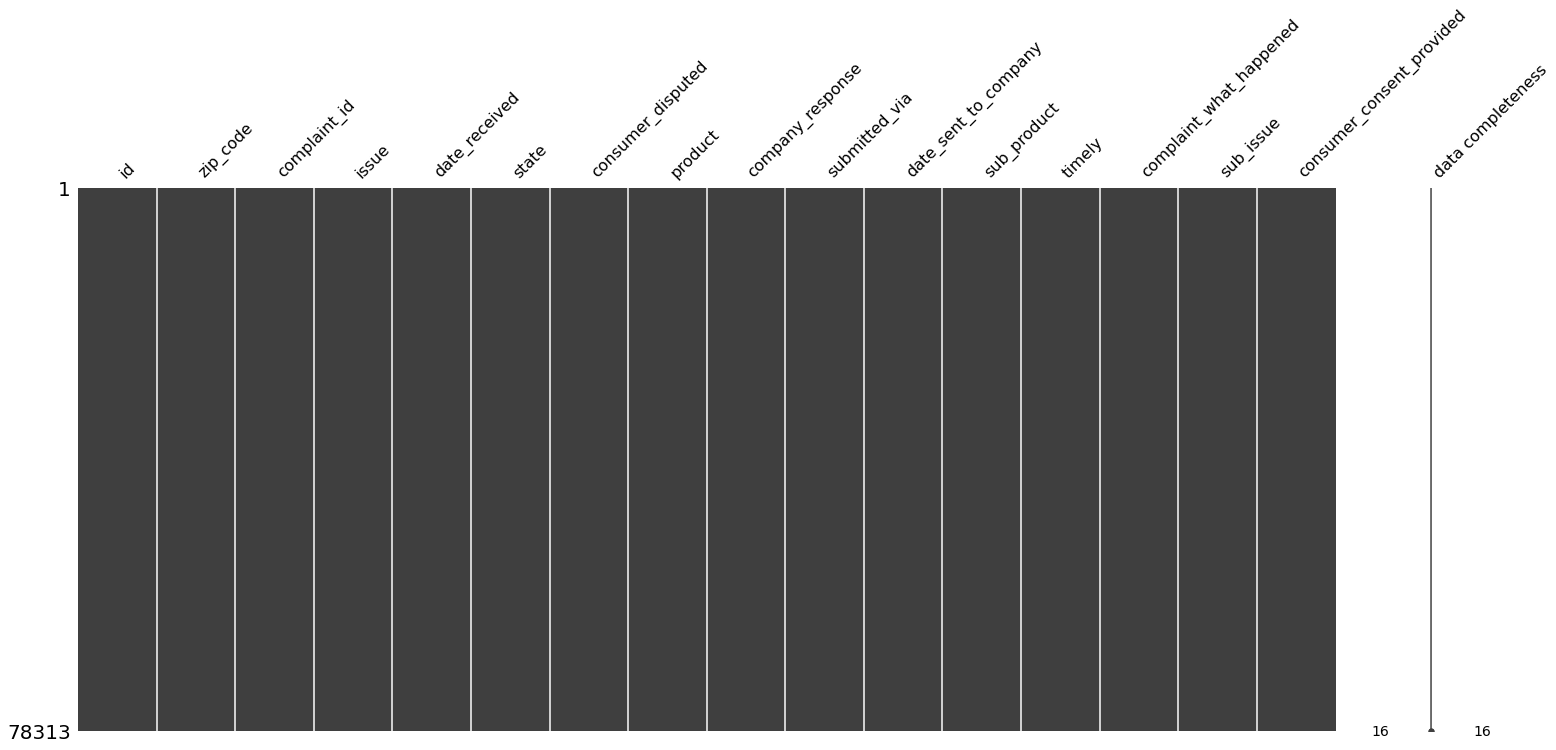

In [273]:
msno.matrix(df,labels=True,sort="descending")

In [274]:
df["issue"].isnull().value_counts()
df["complaint_what_happened"].isnull().value_counts()

print(df["complaint_what_happened"])
print(df["complaint_what_happened"].isnull().value_counts())
df = df.rename(columns={"complaint_what_happened":"complaints"})

0                                               
1        Good morning my name is XXXX XXXX an...
2        I upgraded my XXXX XXXX card in XX/X...
3                                               
4                                               
                          ...                   
78308                                           
78309    On Wednesday, XX/XX/XXXX I called Ch...
78310    I am not familiar with XXXX pay and ...
78311    I have had flawless credit for 30 yr...
78312    Roughly 10+ years ago I closed out m...
Name: complaint_what_happened, Length: 78313, dtype: object
False    78313
Name: complaint_what_happened, dtype: int64


In [275]:
#Assign nan in place of blanks in the complaints column
df["complaints"] = df["complaints"].replace(r'^\s+$', np.nan, regex=True)
df["complaints"] = df["complaints"].replace(r'^$', np.nan, regex=True)

In [276]:
#Remove all rows where complaints column is nan
print(df["complaints"].isnull().value_counts())
df = df.dropna()
print(df["complaints"].isnull().value_counts())

True     57241
False    21072
Name: complaints, dtype: int64
False    21072
Name: complaints, dtype: int64


In [277]:
# Let us confirm that we don't have any null valued cell in the entire dataframe.
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         21072 non-null  object
 1   zip_code                   21072 non-null  object
 2   complaint_id               21072 non-null  object
 3   issue                      21072 non-null  object
 4   date_received              21072 non-null  object
 5   state                      21072 non-null  object
 6   consumer_disputed          21072 non-null  object
 7   product                    21072 non-null  object
 8   company_response           21072 non-null  object
 9   submitted_via              21072 non-null  object
 10  date_sent_to_company       21072 non-null  object
 11  sub_product                21072 non-null  object
 12  timely                     21072 non-null  object
 13  complaints                 21072 non-null  object
 14  sub_is

In [278]:
print(df.columns)

Index(['id', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state',
       'consumer_disputed', 'product', 'company_response', 'submitted_via',
       'date_sent_to_company', 'sub_product', 'timely', 'complaints',
       'sub_issue', 'consumer_consent_provided'],
      dtype='object')


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [279]:
import contractions

def clean_df_column(df_series):

    # Function to process incoming data frame series and output cleaned dataframe series
    
    # Lower case and replace \n i.e. newline charater
    df_series = df_series.str.lower().astype('str')
    df_series = df_series.str.replace('\n','')
    
    # Let us expand english contractions e.g. I've 
    df_series = df_series.apply(lambda x: contractions.fix(x))
    df_series = df_series.astype(str)
    
    # remove words in square brackets as asked in the exercise
    df_series = df_series.str.replace(r'\b\[.*?\]\b','',regex=True).astype(str)
    
    # remove all punctuation charaters
    df_series = df_series.str.replace(r'[^\w\s]+','',regex=True).astype(str)
    
    # remove all words with digits in those.
    df_series = df_series.str.replace(r'\b\w*\d+\w*\b','',regex=True).astype(str)
    
    # Remove XXXX i.e. masked names
    df_series = df_series.str.replace('xxxx','').astype(str)
    
    # compress multiple blank charaters in succession into a single space charater
    df_series = df_series.str.replace(r'\s+',' ',regex=True).astype(str)
    
    # Remove any spaces at the start and end of the string
    df_series = df_series.str.replace(r'^\s+|\s+$','',regex=True).astype(str)
    
    return df_series

In [280]:
# Assign clean_complaints series to cleaned output
df["clean_complaints"] = clean_df_column(df["complaints"])

In [281]:
pd.set_option('display.max_colwidth', None)
print(df["clean_complaints"] )
pd.set_option('display.max_colwidth', 40)

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [282]:
#Write your function to Lemmatize the texts
nlp = spacy.load("en_core_web_sm")

def pos_lemmatize(row):
    # Accept each row i.e. series and fidn lemma_ and pos_ for each row i.e. complaint
    # returns : lemma and pos for each complaint
    
    nlp_list = nlp(row.values[0])
    x = " ".join([w.lemma_ for w in nlp_list])
    y = " ".join([w.pos_ for w in nlp_list])
    return x, y

# temp copy of one column only
df_temp = df[["clean_complaints"]].copy()

df_temp[['clean_complaints_lemma', 'clean_complaints_pos']] = df_temp.apply(
    lambda row: pd.Series(pos_lemmatize(row)), axis=1
)


In [283]:
# Saving to csv file for quick reading later upon notebook closure.
df_temp.to_csv("df_temp.csv")

In [284]:
df_temp = pd.read_csv("df_temp.csv",header=0,index_col=0)
df_temp.index.name = "Id"
df_temp = df_temp.reset_index()
df_temp.index.name = "row_number"

In [285]:
print(df_temp.head())

            Id                         clean_complaints  \
row_number                                                
0            1  good morning my name is and i apprec...   
1            2  i upgraded my card in and was told b...   
2           10  chase card was reported on however f...   
3           11  on while trying to book a ticket i c...   
4           14  my grand son give me check for i dep...   

                             clean_complaints_lemma  \
row_number                                            
0           good morning my name be and I apprec...   
1           I upgrade my card in and be tell by ...   
2           chase card be report on however frau...   
3           on while try to book a ticket I come...   
4           my grand son give I check for I depo...   

                               clean_complaints_pos  
row_number                                           
0           ADJ NOUN PRON NOUN AUX CCONJ PRON VE...  
1           PRON VERB PRON NOUN ADP CC

In [286]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df_temp[['Id', 'clean_complaints', 'clean_complaints_lemma']]

In [287]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
    lem = str(text["clean_complaints_lemma"])
    pos = str(text["clean_complaints_pos"])
 
    # in case, field is blank or nan, let us drop it by converting it as NOUN / unknown
    if(pos == "" or pos == np.nan or pos == "nan"): 
        pos = "UNK"
    if(lem == "" or lem == np.nan or lem == "nan"):
        lem = "unknown"
    
    # If it is noun, we want to include in the tokens
    idx_list = [ idx for idx,id in enumerate(pos.split(" ")) if id == 'NOUN' ]

    if(idx_list and len(idx_list) > 0):
        lem_list = [ lem.split()[each_idx] for each_idx in idx_list ] 
        #print(lem_list)
    else:
        lem_list_return = "unknown"
        return lem_list_return
   
    if(lem_list and len(lem_list) > 0):
        lem_list_return = " ".join(lem_list)
    else:
        lem_list_return = "unknown"

    return lem_list_return

# temp copy of required columns only
df_temp_2 = df_temp[['clean_complaints_lemma', 'clean_complaints_pos']].copy()
        
#df_clean["complaint_POS_removed"] =  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = df_temp_2.apply(
    lambda row: pd.Series(pos_tag(row)), axis=1
)


In [288]:
# saving to csv in case we close notebook 
df_clean.to_csv("df_clean.csv",header=True)

In [289]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean = pd.read_csv("df_clean.csv",header=0,index_col=0)
df_clean.head()

,Id,clean_complaints,clean_complaints_lemma,complaint_POS_removed
row_number,,,,
0,1,good morning my name is and i apprec...,good morning my name be and I apprec...,morning name stop bank cardmember se...
1,2,i upgraded my card in and was told b...,I upgrade my card in and be tell by ...,card agent anniversary date agent in...
2,10,chase card was reported on however f...,chase card be report on however frau...,card application identity consent se...
3,11,on while trying to book a ticket i c...,on while try to book a ticket I come...,ticket offer ticket reward card info...
4,14,my grand son give me check for i dep...,my grand son give I check for I depo...,son check chase account fund chase a...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [290]:
# Write your code here to visualise the data according to the 'Complaint' character length
sentence_lengths = [ len(str(x)) for x in df_clean["clean_complaints"].to_list() ]
print(sentence_lengths[0:10])

[439, 296, 209, 1404, 442, 29, 2217, 1307, 3398, 127]


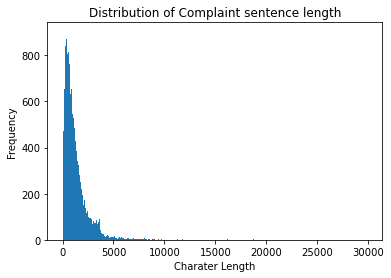

In [291]:
import matplotlib.pyplot as plt
plt.hist(sentence_lengths, bins=500)
plt.xlabel("Charater Length")
plt.ylabel("Frequency")
plt.title("Distribution of Complaint sentence length")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

morning name stop bank cardmember service debt verification statement bank debt mail month debt righ


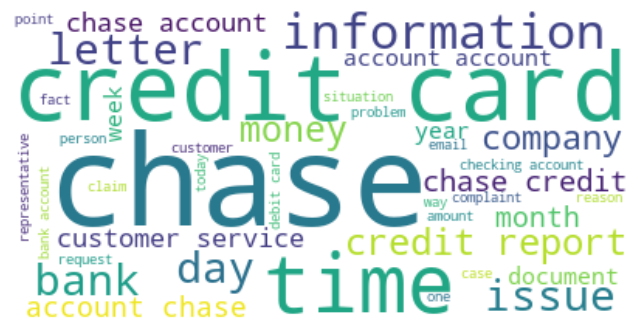

In [292]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

text = " ".join([ review for review in df_clean["complaint_POS_removed"] ])
print(text[0:100])

# Blank Image file to be opened and converted into numpy array
image = Image.open("Blank.jpg")
# Convert the image to a numpy array
image_array = np.array(image)

# Generate the word cloud
wordcloud = WordCloud(background_color='white', max_words=40, stopwords=STOPWORDS).generate(text)

# Create a new figure and plot the word cloud
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Display the word cloud
plt.show()

In [293]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [294]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
import nltk 
from nltk import word_tokenize
from nltk.util import ngrams

tokens = word_tokenize(text)


In [295]:
#Print the top 10 words in the unigram frequency
unigrams = list(ngrams(tokens, 1))
unifreq = nltk.FreqDist(unigrams)
print(unifreq)

uni_dict = dict(sorted(unifreq.items(), key=lambda item: item[1], reverse=True))
uni_dict = dict(list(uni_dict.items())[:10])

<FreqDist with 16010 samples and 1075934 outcomes>


In [296]:
for k,v in uni_dict.items():
    print(k,v)

('chase',) 50762
('account',) 47765
('credit',) 32617
('card',) 30159
('payment',) 21108
('bank',) 17614
('time',) 15993
('day',) 12927
('charge',) 12091
('money',) 11914


In [297]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigrams = list(ngrams(tokens, 2))
bifreq = nltk.FreqDist(bigrams)
print(bifreq)

bi_dict = dict(sorted(bifreq.items(), key=lambda item: item[1], reverse=True))
bi_dict = dict(list(bi_dict.items())[:30])


<FreqDist with 278561 samples and 1075933 outcomes>


In [298]:
#Print the top 10 words in the bigram frequency
bi_dict_10 = dict(list(bi_dict.items())[:10])
for k,v in bi_dict_10.items():
    print(k,v)

('credit', 'card') 12845
('credit', 'report') 3830
('chase', 'credit') 3278
('account', 'chase') 3220
('chase', 'account') 3113
('customer', 'service') 3082
('account', 'account') 2839
('checking', 'account') 2609
('bank', 'account') 2299
('debit', 'card') 2015


In [299]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = list(ngrams(tokens, 3))
trifreq = nltk.FreqDist(trigrams)

print(trifreq)

tri_dict = dict(sorted(trifreq.items(), key=lambda item: item[1], reverse=True))
tri_dict = dict(list(tri_dict.items())[:30])

<FreqDist with 769848 samples and 1075932 outcomes>


In [300]:
#Print the top 10 words in the trigram frequency
tri_dict_10 = dict(list(tri_dict.items())[:10])
for k,v in tri_dict_10.items():
    print(k,v)

('chase', 'credit', 'card') 2289
('_', '_', '_') 1085
('credit', 'card', 'account') 1010
('credit', 'card', 'company') 1003
('credit', 'card', 'chase') 721
('credit', 'card', 'credit') 584
('inquiry', 'credit', 'report') 550
('account', 'credit', 'card') 511
('card', 'credit', 'card') 482
('credit', 'report', 'credit') 394


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [301]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [302]:
#All masked texts has been removed
df_clean.head()

,Id,clean_complaints,clean_complaints_lemma,complaint_POS_removed,Complaint_clean
row_number,,,,,
0,1,good morning my name is and i apprec...,good morning my name be and I apprec...,morning name stop bank cardmember se...,morning name stop bank cardmember se...
1,2,i upgraded my card in and was told b...,I upgrade my card in and be tell by ...,card agent anniversary date agent in...,card agent anniversary date agent in...
2,10,chase card was reported on however f...,chase card be report on however frau...,card application identity consent se...,card application identity consent se...
3,11,on while trying to book a ticket i c...,on while try to book a ticket I come...,ticket offer ticket reward card info...,ticket offer ticket reward card info...
4,14,my grand son give me check for i dep...,my grand son give I check for I depo...,son check chase account fund chase a...,son check chase account fund chase a...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [303]:
#Write your code here to initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english', max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [304]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

# replace any leading and trailing spaces and build corpus from each row in the dataframe column
text = [ re.sub('\s+', ' ', review) for review in df_clean["Complaint_clean"] ]
text = [ re.sub('^\s+|\s+$', '', review) for review in text ]

# TFIDF Vecror building
tfidf_matrix = tfidfvectorizer.fit_transform(text)
dense_matrix = tfidf_matrix.toarray()
feature_names = tfidfvectorizer.get_feature_names_out()
print(tfidf_matrix[0:5])

  (0, 2781)	0.1967098866757134
  (0, 124)	0.2553952844257836
  (0, 5918)	0.25578181274412437
  (0, 34)	0.07829703214812296
  (0, 989)	0.0706441607937621
  (0, 1326)	0.17586697753918823
  (0, 3039)	0.12580742991069505
  (0, 5098)	0.20830863315766188
  (0, 3805)	0.12578672914796185
  (0, 3527)	0.17767810293001596
  (0, 5614)	0.1551612331825574
  (0, 6308)	0.24934696772412435
  (0, 1607)	0.5450614257970949
  (0, 5324)	0.13354562050721877
  (0, 858)	0.31105277682564975
  (0, 503)	0.21012305760969616
  (0, 5657)	0.29577414550528025
  (0, 3821)	0.2289736397421351
  (1, 4843)	0.25147104314192337
  (1, 1301)	0.231360339827172
  (1, 4100)	0.16084922556505374
  (1, 1566)	0.2722441277809068
  (1, 258)	0.6642491389768389
  (1, 165)	0.5635432374022639
  (1, 849)	0.08370862598704949
  :	:
  (3, 3716)	0.11618887041364832
  (3, 5093)	0.12738219476961038
  (3, 4041)	0.44802666705765165
  (3, 5979)	0.3941904632540987
  (3, 1476)	0.1867895688255664
  (3, 293)	0.5177606780814277
  (3, 849)	0.0502425157075

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [305]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [306]:
#Load your nmf_model with the n_components i.e 5

num_topics = 5

#keep the random_state = 40
nmf_model = NMF(n_components=num_topics, init='random', max_iter=300, random_state=40)

In [307]:
nmf_model.fit(dense_matrix)
len(feature_names)

6574

In [308]:
#Print the Top15 words for each of the topics
# Features Matrix
nmf_features = nmf_model.transform(dense_matrix)

# Components Matrix
components_df = pd.DataFrame(nmf_model.components_, 
                            columns=feature_names)

terms =  list(feature_names)

for topic in range(components_df.shape[0]):
    topic_df = components_df.iloc[topic]
    print(f'For topic {topic} the words with the highest value are:')
    print(topic_df.nlargest(15))
    print('\n')

For topic 0 the words with the highest value are:
charge         3.437309
card           2.065950
chase          1.806287
transaction    1.400293
dispute        1.203264
fraud          0.969139
claim          0.935210
merchant       0.934277
fee            0.826706
purchase       0.803255
service        0.707715
time           0.630956
email          0.614017
phone          0.569388
statement      0.533467
Name: 0, dtype: float64


For topic 1 the words with the highest value are:
account        5.006291
check          2.346217
bank           1.843473
money          1.701135
fund           1.367959
chase          1.260493
branch         0.889029
deposit        0.888966
checking       0.868099
day            0.816608
business       0.611334
number         0.590669
transaction    0.532590
fee            0.512221
customer       0.490427
Name: 1, dtype: float64


For topic 2 the words with the highest value are:
loan            2.866975
mortgage        2.018970
home            1.058702
mod

In [309]:
print(components_df.head())

         aa  aaarating      aarp        ab  abandonment  abatement  \
0  0.001156   0.000040  0.011940  0.000000     0.000000   0.000000   
1  0.000681   0.000000  0.000000  0.000000     0.000000   0.000054   
2  0.000099   0.001165  0.000007  0.001735     0.001171   0.001336   
3  0.000000   0.000000  0.013162  0.000000     0.000000   0.000000   
4  0.000314   0.000000  0.000000  0.000000     0.000000   0.000510   

   abbreviation     abide   ability   absence  ...     youth        yr  \
0      0.000128  0.001118  0.014353  0.001807  ...  0.000033  0.004941   
1      0.000000  0.000000  0.030339  0.001238  ...  0.000733  0.003068   
2      0.000978  0.000304  0.048272  0.001900  ...  0.000072  0.022649   
3      0.000000  0.000404  0.037970  0.002031  ...  0.000000  0.000196   
4      0.000000  0.000000  0.028250  0.004456  ...  0.000000  0.011131   

        yrs       yup      zero     zilch       zip   zipcode    zombie  \
0  0.000000  0.000024  0.000088  0.000175  0.008372  0.0000

In [310]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

# temporarily creating custom topic tuple that I can think of
topic_list = ("loan", "account_issues", "credit_card_application", "other" , "credit_card_dispute",)

# create the mapping of Topic and Token Terms

def get_descriptor( terms, H, topic_index, top ):
  # reverse sort the values to sort the indices
  top_indices = np.argsort( H.iloc[topic_index,:] )[::-1]

  # get the terms corresponding to the top-ranked indices
  top_terms = [ ]
  for term_index in top_indices[0:top]:
      top_terms.append( terms[term_index] )
  return top_terms

k = num_topics 
descriptors = [ ]
for topic_index in range(k):
  descriptors.append(get_descriptor(terms, components_df, topic_index, 10 ))
  str_descriptor = ", ".join( descriptors[topic_index] )
  print("Topic %02d %s : %s" % ( topic_index, topic_list[topic_index], str_descriptor ) )


Topic 00 loan : charge, card, chase, transaction, dispute, fraud, claim, merchant, fee, purchase
Topic 01 account_issues : account, check, bank, money, fund, chase, branch, deposit, checking, day
Topic 02 credit_card_application : loan, mortgage, home, modification, chase, property, year, rate, letter, document
Topic 03 other : credit, card, report, inquiry, chase, account, score, company, limit, debt
Topic 04 credit_card_dispute : payment, balance, fee, month, statement, day, chase, time, date, auto


In [311]:
print(df_clean.columns)

Index(['Id', 'clean_complaints', 'clean_complaints_lemma',
       'complaint_POS_removed', 'Complaint_clean'],
      dtype='object')


In [365]:
#Assign the best topic to each of the cmplaints in Topic Column

# Let us check one sample jth complaint.
j = 7
print(pd.DataFrame(nmf_features).loc[j])

predicted_topic = np.argmax(pd.DataFrame(nmf_features).loc[j])
topic_name = topic_list[int(predicted_topic)]
print("\n {}th Document belongs to Topic {} {} ".\
format(j, predicted_topic, topic_name))

pd.set_option('display.max_colwidth', None)
print(df_clean.iloc[j])
pd.set_option('display.max_colwidth', 40)

0    0.005777
1    0.002667
2    0.034936
3    0.000936
4    0.040676
Name: 7, dtype: float64

 7th Document belongs to Topic 4 credit_card_dispute 
Id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [313]:
#df_clean['Topic'] = #write your code to assign topics to each rows.
df_clean["Topic"] = df_clean.apply(lambda row: str(np.argmax(pd.DataFrame(nmf_features).loc[row.name])), axis=1)

In [314]:
df_clean.head()

,Id,clean_complaints,clean_complaints_lemma,complaint_POS_removed,Complaint_clean,Topic
row_number,,,,,,
0,1,good morning my name is and i apprec...,good morning my name be and I apprec...,morning name stop bank cardmember se...,morning name stop bank cardmember se...,1
1,2,i upgraded my card in and was told b...,I upgrade my card in and be tell by ...,card agent anniversary date agent in...,card agent anniversary date agent in...,3
2,10,chase card was reported on however f...,chase card be report on however frau...,card application identity consent se...,card application identity consent se...,3
3,11,on while trying to book a ticket i c...,on while try to book a ticket I come...,ticket offer ticket reward card info...,ticket offer ticket reward card info...,3
4,14,my grand son give me check for i dep...,my grand son give I check for I depo...,son check chase account fund chase a...,son check chase account fund chase a...,1


In [315]:
#Print the first 5 Complaint for each of the Topics
df_clean_print=df_clean.groupby('Topic').head(5)
df_clean_print.sort_values('Topic')

,Id,clean_complaints,clean_complaints_lemma,complaint_POS_removed,Complaint_clean,Topic
row_number,,,,,,
13,30,to whom it may concern chase bank ch...,to whom it may concern chase bank ch...,concern chase bank overdraft fee ale...,concern chase bank overdraft fee ale...,0
19,45,i made a purchase with on in the amo...,I make a purchase with on in the amo...,purchase amount transaction dispute ...,purchase amount transaction dispute ...,0
16,40,a sofa love seat table and chairs an...,a sofa love seat table and chair and...,sofa love seat table chair debit car...,sofa love seat table chair debit car...,0
14,32,my chase amazon card was declined fo...,my chase amazon card be decline for ...,chase amazon card catering order bro...,chase amazon card catering order bro...,0
8,21,on i made a payment to an online ret...,on I make a payment to an online ret...,payment retailer pay chase website s...,payment retailer pay chase website s...,0
12,27,i opened an account with chase bank ...,I open an account with chase bank on...,account code bonus term account depo...,account code bonus term account depo...,1
10,24,mishandling of this account by chase...,mishandle of this account by chase a...,account chase auto,account chase auto,1
0,1,good morning my name is and i apprec...,good morning my name be and I apprec...,morning name stop bank cardmember se...,morning name stop bank cardmember se...,1
6,17,with out notice jp morgan chase rest...,with out notice jp morgan chase rest...,notice account debit card branch cus...,notice account debit card branch cus...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [316]:
print(df_clean.head())

            Id                         clean_complaints  \
row_number                                                
0            1  good morning my name is and i apprec...   
1            2  i upgraded my card in and was told b...   
2           10  chase card was reported on however f...   
3           11  on while trying to book a ticket i c...   
4           14  my grand son give me check for i dep...   

                             clean_complaints_lemma  \
row_number                                            
0           good morning my name be and I apprec...   
1           I upgrade my card in and be tell by ...   
2           chase card be report on however frau...   
3           on while try to book a ticket I come...   
4           my grand son give I check for I depo...   

                              complaint_POS_removed  \
row_number                                            
0           morning name stop bank cardmember se...   
1           card agent anniversary 

In [317]:
#Create the dictionary of Topic names and Topics

# cusomt topiclist we created earlier, let us now map to what Exercise provided us.
#topic_list = ("loan", "account_issues", "credit_card_application", "other" , "credit_card_dispute",)

# This order is important 
Topic_names = {"0":"Mortegate/Loan", "1":"Bank Account services", "2": "Credit card or prepaid card" ,
               "3":"Other", "4":"Theft/Dispute Reporting" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(str).map(Topic_names)

In [318]:
print(df_clean.head())

            Id                         clean_complaints  \
row_number                                                
0            1  good morning my name is and i apprec...   
1            2  i upgraded my card in and was told b...   
2           10  chase card was reported on however f...   
3           11  on while trying to book a ticket i c...   
4           14  my grand son give me check for i dep...   

                             clean_complaints_lemma  \
row_number                                            
0           good morning my name be and I apprec...   
1           I upgrade my card in and be tell by ...   
2           chase card be report on however frau...   
3           on while try to book a ticket I come...   
4           my grand son give I check for I depo...   

                              complaint_POS_removed  \
row_number                                            
0           morning name stop bank cardmember se...   
1           card agent anniversary 

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [319]:
#Create the dictionary again of Topic names and Topics

Topic_names = { "Mortegate/Loan":0, "Bank Account services":1 , "Credit card or prepaid card":2,
              "Other":3, "Theft/Dispute Reporting":4 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [320]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["clean_complaints", "Topic"]]

In [321]:
print(training_data.head())
print(training_data.shape)

                                   clean_complaints  Topic
row_number                                                
0           good morning my name is and i apprec...      1
1           i upgraded my card in and was told b...      3
2           chase card was reported on however f...      3
3           on while trying to book a ticket i c...      3
4           my grand son give me check for i dep...      1
(21072, 2)


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [322]:
#Write your code to get the Vector count
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

corpus = df["clean_complaints"].to_list()
print(corpus[0])

count_vec = CountVectorizer()
word_count_vec = count_vec.fit_transform(corpus)
word_count_cols = list(count_vec.vocabulary_.keys())
print(list(count_vec.vocabulary_.keys())[0:10])
print(word_count_vec.shape)


good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help
['good', 'morning', 'my', 'name', 'is', 'and', 'appreciate', 'it', 'if', 'you']
(21072, 34267)


In [323]:
counts_df = pd.DataFrame(word_count_vec.toarray(), index=training_data.index, columns=word_count_cols)

In [324]:
print(counts_df.head())

            good  morning  my  name  is  and  appreciate  it  if  you  ...  \
row_number                                                             ...   
0              0        0   0     0   0    0           0   0   0    0  ...   
1              0        0   0     0   0    0           0   0   0    0  ...   
2              0        0   0     0   0    0           0   0   0    0  ...   
3              0        0   0     0   0    0           0   0   0    0  ...   
4              0        0   0     0   0    0           0   0   0    0  ...   

            godsend  withave  notrtous  escalting  unbelievebi  \
row_number                                                       
0                 0        0         0          0            0   
1                 0        0         0          0            0   
2                 0        0         0          0            0   
3                 0        0         0          0            0   
4                 0        0         0          0        

In [325]:
#Write your code here to transform the word vector to tf-idf
tf_transformer = TfidfTransformer(use_idf=True).fit(word_count_vec)
word_count_vec_tf = tf_transformer.transform(word_count_vec)
print(word_count_vec_tf.shape)

(21072, 34267)


In [326]:
corpus_tf_idf = pd.DataFrame(word_count_vec_tf.toarray(), index=training_data.index, columns=word_count_cols)
#corpus_tf_idf["Topic"] = training_data["Topic"]
print(corpus_tf_idf.head())
print(corpus_tf_idf.shape)


            good  morning   my  name   is  and  appreciate   it   if  you  \
row_number                                                                  
0            0.0      0.0  0.0   0.0  0.0  0.0         0.0  0.0  0.0  0.0   
1            0.0      0.0  0.0   0.0  0.0  0.0         0.0  0.0  0.0  0.0   
2            0.0      0.0  0.0   0.0  0.0  0.0         0.0  0.0  0.0  0.0   
3            0.0      0.0  0.0   0.0  0.0  0.0         0.0  0.0  0.0  0.0   
4            0.0      0.0  0.0   0.0  0.0  0.0         0.0  0.0  0.0  0.0   

            ...  godsend  withave  notrtous  escalting  unbelievebi  \
row_number  ...                                                       
0           ...      0.0      0.0       0.0        0.0          0.0   
1           ...      0.0      0.0       0.0        0.0          0.0   
2           ...      0.0      0.0       0.0        0.0          0.0   
3           ...      0.0      0.0       0.0        0.0          0.0   
4           ...      0.0      0.0 

In [327]:
from sklearn.model_selection import train_test_split

#target_attribute = training_data['Topic'].iloc[0:5000]
#corpus_tf_idf_t = corpus_tf_idf.iloc[0:5000]

target_attribute = training_data['Topic']
X_train, X_test, y_train, y_test = train_test_split(corpus_tf_idf, target_attribute, test_size=0.2)

In [328]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16857, 34267) (4215, 34267) (16857,) (4215,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [329]:
# Write your code here to build any 3 models and evaluate them using the required metrics

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble  import RandomForestClassifier


def logigistic_regression(X_train,y_train):
    model = LogisticRegression()
    model.fit(X_train,y_train)
    return model

def decision_tree(X_train,y_train,max_depth=5,max_features=None):
    model = DecisionTreeClassifier(max_depth=max_depth,max_features=max_features)
    model.fit(X_train,y_train)
    return model

def randomforest(X_train,y_train,max_depth=5,max_features=None):
    model = DecisionTreeClassifier(max_depth=max_depth,max_features=max_features)
    model.fit(X_train,y_train)
    return model


In [330]:
def score_model(y_test,y_pred):
    

    # Confusion metrics
    confusion = metrics.confusion_matrix(y_test, y_pred)
    print(confusion)

    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    
    Accuracy = accuracy_score(y_test,y_pred)
    Precision= precision_score(y_test,y_pred,average='macro', zero_division=0.0)
    Recall = recall_score(y_test,y_pred,average='macro', zero_division=0.0)
    Sensitivity = round((TP / float(TP+FN)),2)
    Specificity = round((TN / float(TN+FP)),2)
    False_positive_rate = round( (FP/ float(TN+FP)), 4) * 100
    True_positive_rate = round( (TP / float(TP+FP)), 4)* 100
    True_negative_rate = round( (TN / float(TN+ FN)), 4) * 100
    F1_score = f1_score(y_test, y_pred, average="macro")
    classification_err_rate = round( ((FP+FN) / float(TP+FP+TN+FN)), 4)* 100
    
    results = { 'accuracy' : Accuracy,
                'precision' : Precision,
                'recall'  :  Recall,
                'sensitivity' :Sensitivity,
                'sensitivity' :   Specificity,
                'false_positive_rate' :True_positive_rate,
                'true_positive_rate' : True_negative_rate,
                'true_negative_rate' : True_negative_rate ,
                'f1_score' : F1_score ,
                'Classification_error_rate': classification_err_rate,
               }
    return results

In [331]:
def create_models(classifier,X_train,y_train,X_test,y_test,scale=False):
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =test_size, random_state = 4, stratify = y)
    
    if scale:
        scaler = StandardScaler()
        cols_scale = X_train.columns.to_list()
        X_train_sdf = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train_sdf, columns=cols_scale)
        X_test = scaler.transform(X_test)
    
    
    model = classifier(X_train,y_train)
    
    y_pred_test = model.predict(X_test)
    y_test_pred = pd.DataFrame({'ground_truth':y_test.values, 'prediction':y_pred_test})

    summary_test = score_model(y_test,y_test_pred['prediction'])    
    
    prediction_results = pd.DataFrame({'y_test' : y_test,
                                       'y_pred' : y_test_pred['prediction']},
                                    )
    model_crosstab = pd.crosstab(prediction_results['y_pred'],prediction_results['y_test'])
    
    model_results  = { 
                       'test'     : summary_test,
                       'confusion_matrix' : model_crosstab,
                     }
    return model,model_results

In [332]:
# Let us try three models and store results in model_results

models_results = {}
lr_model,models_results['LogisticRegression'] = create_models(
    logigistic_regression,X_train,y_train,X_test,y_test)

/Users/dhananjayjoshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[[ 779   28    9   19    5]
 [  23 1089   12   17    2]
 [  14    8  706   12    4]
 [  36   18    5  954    2]
 [  18   18   21   18  398]]


In [333]:
print(model_results)

                           LogisticRegression  DecisionTree  RandomForest
accuracy                             0.918149      0.741400      0.741400
precision                            0.923535      0.788445      0.788445
recall                               0.901503      0.729275      0.729275
sensitivity                          0.990000      0.950000      0.950000
false_positive_rate                 99.460000     95.820000     95.820000
true_positive_rate                  98.680000     95.010000     95.010000
true_negative_rate                  98.680000     95.010000     95.010000
f1_score                             0.910716      0.748840      0.748840
Classification_error_rate            0.930000      4.560000      4.560000


In [334]:
decisiontree_model,models_results['DecisionTree'] = create_models(
    decision_tree,X_train,y_train,X_test,y_test)

[[495  68 206  60  11]
 [ 58 759 248  54  24]
 [ 21  11 675  22  15]
 [130  43  53 779  10]
 [ 24  37  84  43 285]]


In [335]:
randonforest_model,models_results['RandomForest'] = create_models(
    randomforest,X_train,y_train,X_test,y_test)

[[495  68 206  60  11]
 [ 58 759 248  54  24]
 [ 21  11 675  22  15]
 [130  43  53 779  10]
 [ 24  37  84  43 285]]


In [336]:
model_results = pd.DataFrame()

for key in models_results:
    for result,value in models_results[key]['test'].items():
        ind = [ result for result,value in models_results[key]['test'].items()]   
        values = [ value for result,value in models_results[key]['test'].items()] 

    df_tmp = pd.DataFrame(values,index=ind,columns=[key])
    model_results = pd.concat([model_results,df_tmp],axis=1)

display(model_results.T.sort_values('accuracy',ascending=False))

,accuracy,precision,recall,sensitivity,false_positive_rate,true_positive_rate,true_negative_rate,f1_score,Classification_error_rate
LogisticRegression,0.931435,0.934927,0.922080,0.97,97.49,97.13,97.13,0.927538,2.66
DecisionTree,0.710083,0.735831,0.706122,0.88,91.78,89.51,89.51,0.705207,9.13
RandomForest,0.710083,0.735831,0.706122,0.88,91.78,89.51,89.51,0.705207,9.13


In [337]:
print(model_results)

                           LogisticRegression  DecisionTree  RandomForest
accuracy                             0.931435      0.710083      0.710083
precision                            0.934927      0.735831      0.735831
recall                               0.922080      0.706122      0.706122
sensitivity                          0.970000      0.880000      0.880000
false_positive_rate                 97.490000     91.780000     91.780000
true_positive_rate                  97.130000     89.510000     89.510000
true_negative_rate                  97.130000     89.510000     89.510000
f1_score                             0.927538      0.705207      0.705207
Classification_error_rate            2.660000      9.130000      9.130000


In [369]:
# Conclusion LogisticRegression is best performing model with 0.93 as F1 score
# Let us use it to predict topic against some text

# Picking up same text as above which should be predicted to topic-4 i,e. credit card dispute

inference_corpus = ['summer month decline income employment month payment extension auto loan \
                    company chase past year request payment extension auto loan payment request \
                    month payment extension year situation supervisor avail discussion reason decline \
                    reason denial office director communication representative chase week representative \
                    office representative role help matter representative conference call department \
                    request information request policy change explanation representative letter \
                    explanation letter reason denial policy change cfpb help denial payment extension \
                    request reason denial']

# Let us create tf_idf matrix before feeding to Logstic regression model.

# transform countvector and TF vector with unseen text
inference_tfidf = count_vec.transform(inference_corpus)
inference_df = pd.DataFrame(inference_tfidf.toarray(), columns=word_count_cols)

inference_transformer = TfidfTransformer(use_idf=True).fit(inference_tfidf)
inf_word_count_vec_tf = inference_transformer.transform(inference_tfidf)
inf_tf_idf = pd.DataFrame(inf_word_count_vec_tf.toarray(), columns=word_count_cols)
print(inf_tf_idf,inf_tf_idf.shape)

   good  morning   my  name   is  and  appreciate   it   if  you  ...  \
0   0.0      0.0  0.0   0.0  0.0  0.0         0.0  0.0  0.0  0.0  ...   

   godsend  withave  notrtous  escalting  unbelievebi  constellations  \
0      0.0      0.0       0.0        0.0          0.0             0.0   

   helpsince  legitamite  mogul  freeedom  
0        0.0         0.0    0.0       0.0  

[1 rows x 34267 columns] (1, 34267)


In [371]:
topic_number = lr_model.predict(inf_tf_idf)
print(topic_number)

[4]


In [372]:
# Conclusion - Model correctly predicts topic-4 i.e. credit card dispute topic for chosen text.